<a href="https://colab.research.google.com/github/Baimiyk/2025_VisiKomputer_TI2C/blob/main/jobsheet3_regresi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 01

# Praktikum 02

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"baimmrn","key":"c30cfd419d8415db09045fc44b3d7fe4"}'}

In [ ]:
import os, shutil

if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap Digunakan ")
else:
  print("Kaggle API belum di upload")

Kaggle API siap Digunakan 


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak.


Total Gambar ditemukan: 23708


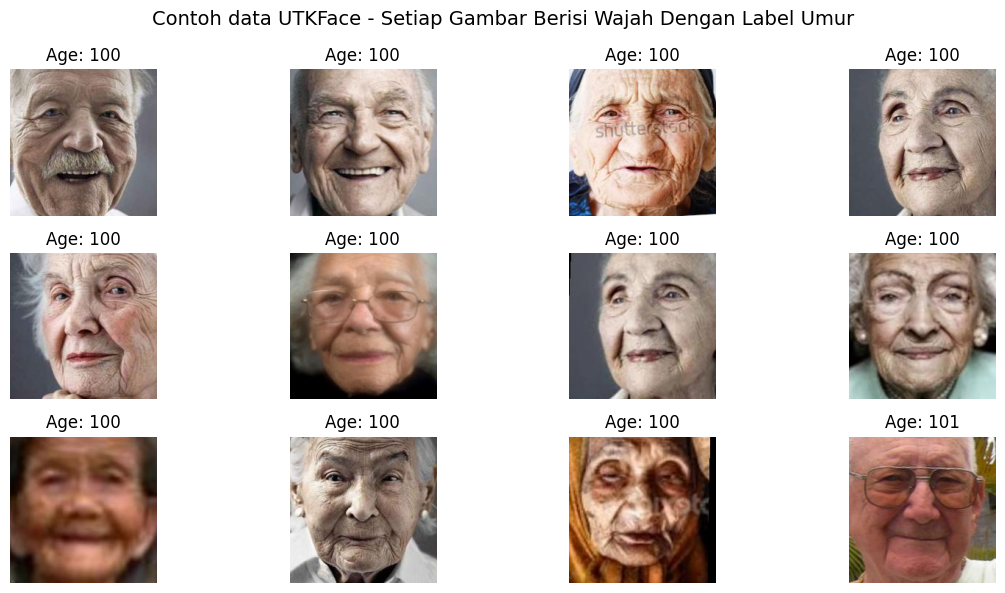

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total Gambar ditemukan: {len(files)}")

plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  # Split the filename by underscore and take the first part as age
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i+1)
  plt.imshow(img)
  plt.title(f"Age: {age}")
  plt.axis("off")
plt.suptitle("Contoh data UTKFace - Setiap Gambar Berisi Wajah Dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])
ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")
# Buat arsitektur model

base_model = tf.keras.applications.MobileNetV2(
  include_top=False,
  input_shape=(IMG_SIZE, IMG_SIZE, 3),
  weights='imagenet')

base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
  loss='mse', metrics=['mae'])
model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 55s 127ms/step - loss: 354.2361 - mae: 13.8249 - val_loss: 162.0614 - val_mae: 9.7168 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 158.1462 - mae: 9.3426 - val_loss: 149.0175 - val_mae: 9.2185 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 145.4541 - mae: 8.8779 - val_loss: 142.2969 - val_mae: 8.9361 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 140.0537 - mae: 8.7443 - val_loss: 137.7248 - val_mae: 8.7095 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 137.0904 - mae: 8.6158 - val_loss: 137.6644 - val_mae: 8.7632 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 134.4095 - mae: 8.5073 - val_loss: 134.2472 - val_mae: 8.5957 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 131.9617 - mae: 8.4148 - val_loss: 136.5784 - va

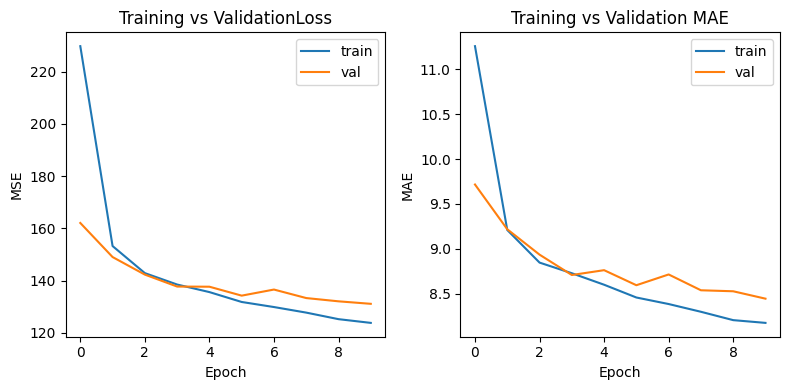

In [20]:
# Callback untuk pelatihan yang lebih stabil
cb = [
  tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True,
monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=10,
  callbacks=cb,
  verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs ValidationLoss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - loss: 188.8060 - mae: 10.1573 - val_loss: 142.7421 - val_mae: 9.0342 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 76.3195 - mae: 6.5438 - val_loss: 129.8126 - val_mae: 8.7484 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 52.8478 - mae: 5.5175 - val_loss: 111.3809 - val_mae: 7.8433 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 36.5707 - mae: 4.6319 - val_loss: 105.0873 - val_mae: 7.4756 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 29.0279 - mae: 4.1308 - val_loss: 107.8506 - val_mae: 7.6650 - learning_rate: 1.0000e-04


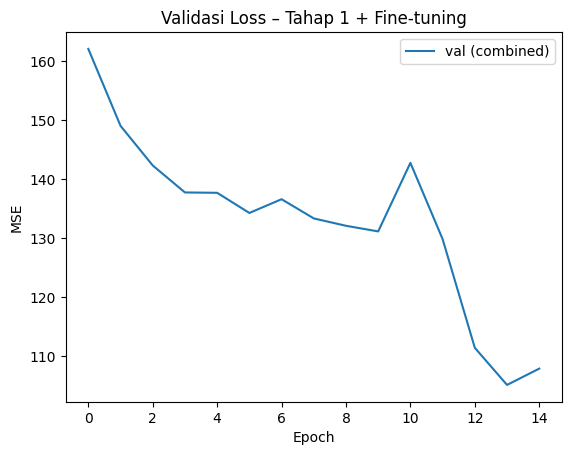

In [21]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
loss='mse', metrics=['mae'])
history_ft = model.fit(
train_ds,
validation_data=test_ds,
epochs=5,
callbacks=cb,
verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

MAE = 7.48 tahun
RMSE = 10.25 tahun
R2 = 0.735


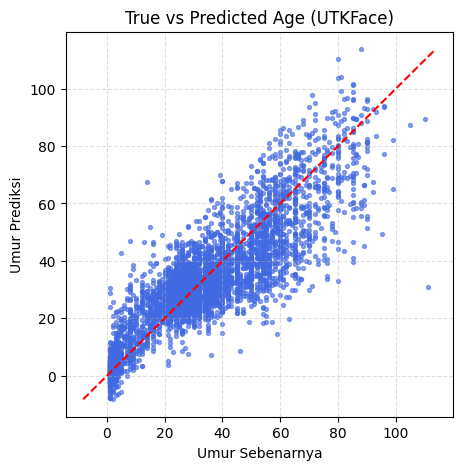

In [22]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for
batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R2 = {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

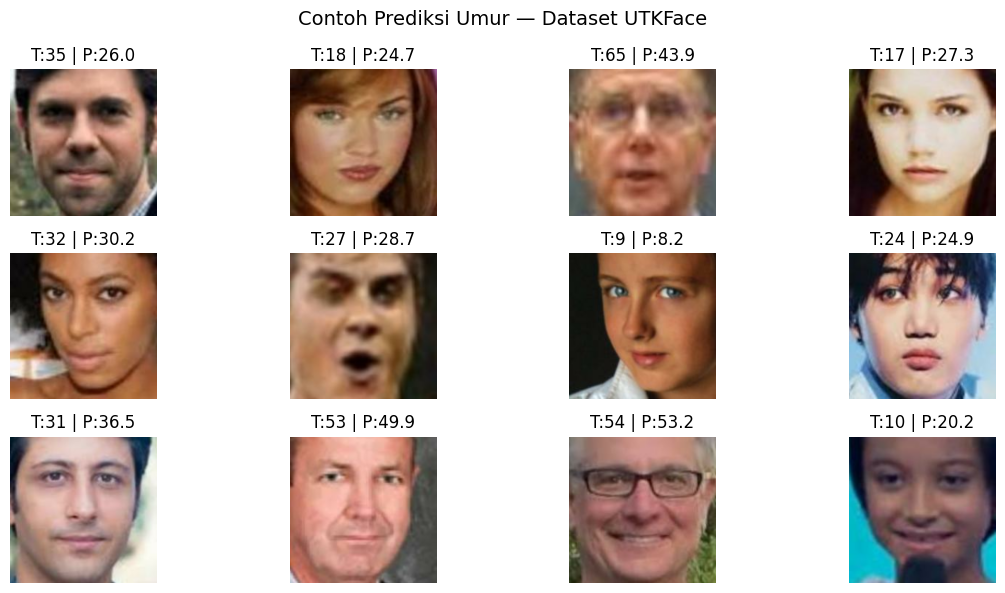

In [23]:
import random
sample_paths = random.sample(test_files, 12)
plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')
plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()